In [13]:
# Extensions
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import ray
from ray import tune
import seqdatasets
import torch
from eugene import preprocess as pp
from eugene.train._hyperopt_ray import hyperopt
from eugene.models import get_model
import importlib
from eugene.models import SequenceModule
from eugene.models.zoo import CNN
from eugene import models

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
ray.init(num_cpus=4, num_gpus=1)

2023-05-25 14:45:13,254	INFO worker.py:1625 -- Started a local Ray instance.


Python version:,3.9.16
Ray version:,2.4.0


In [3]:
sdata = seqdatasets.random1000()
pp.ohe_seqs_sdata(sdata)
pp.make_unique_ids_sdata(sdata)
pp.train_test_split_sdata(sdata)
sdata["ohe_seq"] = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length")
sdata

0it [00:00, ?it/s]

1000it [00:00, 2159.04it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 1000, _ohe: 4, length: 100, id: 1000)
Coordinates:
  * id          (id) <U7 'seq0000' 'seq0001' 'seq0002' ... 'seq0998' 'seq0999'
Dimensions without coordinates: _sequence, _ohe, length
Data variables: (12/24)
    activity_0  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_1  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_2  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_3  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_4  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    activity_5  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    ...          ...
    label_8     (_sequence) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    label_9     (_sequence) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    name        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    ohe_seq     (_sequence, _ohe, length) uint8 0 0 0 0 1 0 0 ... 1 0 0 0 0 0 0
    train_val   (id) bool False False False True ... False False False False
Attributes:
    max_jitter:  0

In [4]:
tune_config = {
    "module": "SequenceModule",
    "model": {
    "arch_name": "CNN",
    "model_name": "hyper_funkytiger",
    "arch": {
      "input_len": 100,
      "output_dim": 2,
      "conv_kwargs": {
        "input_channels": 4,
        "conv_channels": [tune.choice([32, 64, 128, 256, 512]), tune.choice([32, 64, 128, 256, 512]), tune.choice([32, 64, 128, 256, 512])],
        "conv_kernels": [tune.choice([3, 5, 7]), tune.choice([3, 5, 7]), tune.choice([3, 5, 7])],
        "pool_kernels": [tune.choice([1, 2]), tune.choice([1, 2]), tune.choice([1, 2])],
        "dropout_rates": 0.1,
        "batchnorm": True
      },
      "dense_kwargs": {
        "hidden_dims": [tune.choice([32, 64, 128, 256, 512]), tune.choice([32, 64, 128, 256, 512])],
      },
    },
    "task": "regression",
    "loss_fxn": "mse",
    "optimizer": "adam",
    "optimizer_lr": tune.loguniform(1e-4, 1e-1),
  },
  "batch_size": tune.choice([32, 64, 128]),
}

In [5]:
res = hyperopt(
    tune_config,
    sdata=sdata,
    target_keys=["activity_0", "activity_1"],
    train_key="train_val",
    epochs=5,
    seq_transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    gpus=1,
    cpus=4,
    num_samples=5,
    num_workers=0
)

Performing hyperparameter optimization using HyperOpt.


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/ray/tune/experiment/experiment.py:170: UserWarning: The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
  warnings.warn(


(hyperopt_with_tune pid=3565229) {'module': 'SequenceModule', 'model': {'arch_name': 'CNN', 'model_name': 'hyper_funkytiger', 'arch': {'input_len': 100, 'output_dim': 2, 'conv_kwargs': {'input_channels': 4, 'conv_channels': [512, 128, 64], 'conv_kernels': [5, 7, 7], 'pool_kernels': [2, 1, 2], 'dropout_rates': 0.1, 'batchnorm': True}, 'dense_kwargs': {'hidden_dims': [512, 32]}}, 'task': 'regression', 'loss_fxn': 'mse', 'optimizer': 'adam', 'optimizer_lr': 0.0033596391919626938}, 'batch_size': 32}
(hyperopt_with_tune pid=3565229) Model: SequenceModule(
(hyperopt_with_tune pid=3565229)   (arch): CNN(
(hyperopt_with_tune pid=3565229)     (conv1d_tower): Conv1DTower(
(hyperopt_with_tune pid=3565229)       (layers): Sequential(
(hyperopt_with_tune pid=3565229)         (0): Conv1d(4, 512, kernel_size=(5,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3565229)         (1): ReLU()
(hyperopt_with_tune pid=3565229)         (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil

(hyperopt_with_tune pid=3565229) [rank: 0] Global seed set to 13


(hyperopt_with_tune pid=3565229) Dropping 0 sequences with NaN targets.


(hyperopt_with_tune pid=3565229) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
(hyperopt_with_tune pid=3565229)   rank_zero_warn(
(hyperopt_with_tune pid=3565229) GPU available: True (cuda), used: True
(hyperopt_with_tune pid=3565229) TPU available: False, using: 0 TPU cores
(hyperopt_with_tune pid=3565229) IPU available: False, using: 0 IPUs
(hyperopt_with_tune pid=3565229) HPU available: False, using: 0 HPUs
(hyperopt_with_tune pid=3565229) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used.

Sanity Checking: 0it [00:00, ?it/s]65229) 
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(hyperopt_with_tune pid=3565229) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3565229)   rank_zero_warn(


Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s]                             


(hyperopt_with_tune pid=3565229) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3565229)   rank_zero_warn(
(hyperopt_with_tune pid=3565229) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(hyperopt_with_tune pid=3565229)   rank_zero_warn(


Epoch 0: 100%|██████████| 6/6 [00:00<00:00, 10.09it/s, v_num=2]
Validation: 0it [00:00, ?it/s]3565229) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 66.21it/s]


Trial name,date,done,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
hyperopt_with_tune_eb1a0_00000,2023-05-25_14-27-50,True,"0_batch_size=32,0=512,1=128,2=64,0=5,1=7,2=7,0=2,1=1,2=2,0=512,1=32,optimizer_lr=0.0034",carter-gpu-01,5,0.12787,192.168.169.178,3565229,8.50845,0.356458,8.50845,1685050070,5,eb1a0_00000
hyperopt_with_tune_eb1a0_00001,2023-05-25_14-28-19,True,"1_batch_size=128,0=512,1=64,2=128,0=5,1=7,2=7,0=2,1=1,2=1,0=64,1=512,optimizer_lr=0.0005",carter-gpu-01,5,0.323749,192.168.169.178,3565360,6.80279,0.0982823,6.80279,1685050099,5,eb1a0_00001
hyperopt_with_tune_eb1a0_00002,2023-05-25_14-28-49,True,"2_batch_size=64,0=256,1=128,2=256,0=7,1=3,2=7,0=2,1=2,2=1,0=256,1=32,optimizer_lr=0.0206",carter-gpu-01,5,2.30125,192.168.169.178,3565577,8.01062,0.298057,8.01062,1685050129,5,eb1a0_00002
hyperopt_with_tune_eb1a0_00003,2023-05-25_14-29-18,True,"3_batch_size=64,0=64,1=256,2=32,0=3,1=5,2=5,0=2,1=2,2=1,0=256,1=512,optimizer_lr=0.0396",carter-gpu-01,5,0.345111,192.168.169.178,3565694,7.53569,0.242688,7.53569,1685050158,5,eb1a0_00003
hyperopt_with_tune_eb1a0_00004,2023-05-25_14-29-52,True,"4_batch_size=128,0=128,1=64,2=512,0=7,1=5,2=5,0=2,1=1,2=1,0=512,1=64,optimizer_lr=0.0007",carter-gpu-01,5,1.48206,192.168.169.178,3565806,9.5882,0.557457,9.5882,1685050192,5,eb1a0_00004


(hyperopt_with_tune pid=3565229) 
Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 35.07it/s, v_num=2]
(hyperopt_with_tune pid=3565229) 
Validation: 0it [00:00, ?it/s]3565229) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 63.48it/s]
(hyperopt_with_tune pid=3565229) 
Epoch 2: 100%|██████████| 6/6 [00:00<00:00, 41.73it/s, v_num=2]
Validation: 0it [00:00, ?it/s]3565229) 
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 88.71it/s] 
(hyperopt_with_tune pid=3565229) 
Epoch 3: 100%|██████████| 6/6 [00:00<00:00, 35.63it/s, v_num=2]
Validation: 0it [00:00, ?it/s]3565229) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 65.20it/s]
(hyperopt_with_tune pid=3565229) 
Epoch 4: 100%|██████████| 6/6 [00:00<00:00, 40.05it/s, v_num=2]
Validation: 0it [00:00, ?it/s]3565229) 
(hyperopt_with_tune pid=3565229) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 62.77it/s]
(hyperopt_with_tune pid=3565229) 
Epoch 4: 100%|██████████| 6/6 [00:00<00:00, 16.81it/s, v_num=

(hyperopt_with_tune pid=3565229) `Trainer.fit` stopped: `max_epochs=5` reached.


(hyperopt_with_tune pid=3565360) {'module': 'SequenceModule', 'model': {'arch_name': 'CNN', 'model_name': 'hyper_funkytiger', 'arch': {'input_len': 100, 'output_dim': 2, 'conv_kwargs': {'input_channels': 4, 'conv_channels': [512, 64, 128], 'conv_kernels': [5, 7, 7], 'pool_kernels': [2, 1, 1], 'dropout_rates': 0.1, 'batchnorm': True}, 'dense_kwargs': {'hidden_dims': [64, 512]}}, 'task': 'regression', 'loss_fxn': 'mse', 'optimizer': 'adam', 'optimizer_lr': 0.00046715044028652946}, 'batch_size': 128}
(hyperopt_with_tune pid=3565360) Model: SequenceModule(
(hyperopt_with_tune pid=3565360)   (arch): CNN(
(hyperopt_with_tune pid=3565360)       (layers): Sequential(
(hyperopt_with_tune pid=3565360)         (0): Conv1d(4, 512, kernel_size=(5,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3565360)         (1): ReLU()
(hyperopt_with_tune pid=3565360)         (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
(hyperopt_with_tune pid=3565360)         (3): Dropo

(hyperopt_with_tune pid=3565360) [rank: 0] Global seed set to 13


(hyperopt_with_tune pid=3565360) Dropping 0 sequences with NaN targets.


(hyperopt_with_tune pid=3565360) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
(hyperopt_with_tune pid=3565360)   rank_zero_warn(
(hyperopt_with_tune pid=3565360) GPU available: True (cuda), used: True
(hyperopt_with_tune pid=3565360) TPU available: False, using: 0 TPU cores
(hyperopt_with_tune pid=3565360) IPU available: False, using: 0 IPUs
(hyperopt_with_tune pid=3565360) HPU available: False, using: 0 HPUs
(hyperopt_with_tune pid=3565360) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used.

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(hyperopt_with_tune pid=3565360) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3565360)   rank_zero_warn(


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(hyperopt_with_tune pid=3565360) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3565360)   rank_zero_warn(
(hyperopt_with_tune pid=3565360) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(hyperopt_with_tune pid=3565360)   rank_zero_warn(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s, v_num=3]
Validation: 0it [00:00, ?it/s]3565360) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 34.13it/s, v_num=3]
Validation: 0it [00:00, ?it/s]3565360) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 33.30it/s, v_num=3]
Validation: 0it [00:00, ?it/s]3565360) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 33.69it/s, v_num=3]
Validation: 0it [00:00, ?it/s]3565360) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 33.52it/s, v_num=3]
Validation: 0it [00:00, ?it/s]3565360) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s, v_num=3]


(hyperopt_with_tune pid=3565360) `Trainer.fit` stopped: `max_epochs=5` reached.


(hyperopt_with_tune pid=3565577) {'module': 'SequenceModule', 'model': {'arch_name': 'CNN', 'model_name': 'hyper_funkytiger', 'arch': {'input_len': 100, 'output_dim': 2, 'conv_kwargs': {'input_channels': 4, 'conv_channels': [256, 128, 256], 'conv_kernels': [7, 3, 7], 'pool_kernels': [2, 2, 1], 'dropout_rates': 0.1, 'batchnorm': True}, 'dense_kwargs': {'hidden_dims': [256, 32]}}, 'task': 'regression', 'loss_fxn': 'mse', 'optimizer': 'adam', 'optimizer_lr': 0.020604987146028552}, 'batch_size': 64}
(hyperopt_with_tune pid=3565577) Model: SequenceModule(
(hyperopt_with_tune pid=3565577)   (arch): CNN(
(hyperopt_with_tune pid=3565577)     (conv1d_tower): Conv1DTower(
(hyperopt_with_tune pid=3565577)       (layers): Sequential(
(hyperopt_with_tune pid=3565577)         (0): Conv1d(4, 256, kernel_size=(7,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3565577)         (1): ReLU()
(hyperopt_with_tune pid=3565577)         (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil

(hyperopt_with_tune pid=3565577) [rank: 0] Global seed set to 13


(hyperopt_with_tune pid=3565577) Dropping 0 sequences with NaN targets.


(hyperopt_with_tune pid=3565577) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
(hyperopt_with_tune pid=3565577)   rank_zero_warn(
(hyperopt_with_tune pid=3565577) GPU available: True (cuda), used: True
(hyperopt_with_tune pid=3565577) TPU available: False, using: 0 TPU cores
(hyperopt_with_tune pid=3565577) IPU available: False, using: 0 IPUs
(hyperopt_with_tune pid=3565577) HPU available: False, using: 0 HPUs
(hyperopt_with_tune pid=3565577) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used.

Sanity Checking: 0it [00:00, ?it/s]65577) 
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(hyperopt_with_tune pid=3565577) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3565577)   rank_zero_warn(


Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s]                             


(hyperopt_with_tune pid=3565577) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3565577)   rank_zero_warn(
(hyperopt_with_tune pid=3565577) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(hyperopt_with_tune pid=3565577)   rank_zero_warn(


Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s, v_num=4]
Validation: 0it [00:00, ?it/s]3565577) 
Epoch 1: 100%|██████████| 3/3 [00:00<00:00, 42.76it/s, v_num=4]
Validation: 0it [00:00, ?it/s]3565577) 
Epoch 2: 100%|██████████| 3/3 [00:00<00:00, 39.41it/s, v_num=4]
Validation: 0it [00:00, ?it/s]3565577) 
Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]
(hyperopt_with_tune pid=3565577) 
Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 42.80it/s, v_num=4]
Validation: 0it [00:00, ?it/s]3565577) 
Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 91.61it/s] 
(hyperopt_with_tune pid=3565577) 
Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 39.10it/s, v_num=4]
Validation: 0it [00:00, ?it/s]3565577) 
Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 10.30it/s, v_num=4]


(hyperopt_with_tune pid=3565577) `Trainer.fit` stopped: `max_epochs=5` reached.


(hyperopt_with_tune pid=3565694) {'module': 'SequenceModule', 'model': {'arch_name': 'CNN', 'model_name': 'hyper_funkytiger', 'arch': {'input_len': 100, 'output_dim': 2, 'conv_kwargs': {'input_channels': 4, 'conv_channels': [64, 256, 32], 'conv_kernels': [3, 5, 5], 'pool_kernels': [2, 2, 1], 'dropout_rates': 0.1, 'batchnorm': True}, 'dense_kwargs': {'hidden_dims': [256, 512]}}, 'task': 'regression', 'loss_fxn': 'mse', 'optimizer': 'adam', 'optimizer_lr': 0.03957473537283139}, 'batch_size': 64}
(hyperopt_with_tune pid=3565694) Model: SequenceModule(
(hyperopt_with_tune pid=3565694)   (arch): CNN(
(hyperopt_with_tune pid=3565694)     (conv1d_tower): Conv1DTower(
(hyperopt_with_tune pid=3565694)       (layers): Sequential(
(hyperopt_with_tune pid=3565694)         (0): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3565694)         (1): ReLU()
(hyperopt_with_tune pid=3565694)         (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mo

(hyperopt_with_tune pid=3565694) [rank: 0] Global seed set to 13


(hyperopt_with_tune pid=3565694) Dropping 0 sequences with NaN targets.


(hyperopt_with_tune pid=3565694) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
(hyperopt_with_tune pid=3565694)   rank_zero_warn(
(hyperopt_with_tune pid=3565694) GPU available: True (cuda), used: True
(hyperopt_with_tune pid=3565694) TPU available: False, using: 0 TPU cores
(hyperopt_with_tune pid=3565694) IPU available: False, using: 0 IPUs
(hyperopt_with_tune pid=3565694) HPU available: False, using: 0 HPUs
(hyperopt_with_tune pid=3565694) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used.

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(hyperopt_with_tune pid=3565694) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3565694)   rank_zero_warn(


                                                                           
Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s] 


(hyperopt_with_tune pid=3565694) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3565694)   rank_zero_warn(
(hyperopt_with_tune pid=3565694) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(hyperopt_with_tune pid=3565694)   rank_zero_warn(


Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  6.13it/s, v_num=5]
Validation: 0it [00:00, ?it/s]3565694) 
(hyperopt_with_tune pid=3565694) 
Epoch 1: 100%|██████████| 3/3 [00:00<00:00, 26.02it/s, v_num=5]
Validation: 0it [00:00, ?it/s]3565694) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 44.08it/s]
(hyperopt_with_tune pid=3565694) 
Epoch 2: 100%|██████████| 3/3 [00:00<00:00, 26.41it/s, v_num=5]
Validation: 0it [00:00, ?it/s]3565694) 
(hyperopt_with_tune pid=3565694) 
Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 27.36it/s, v_num=5]
Validation: 0it [00:00, ?it/s]3565694) 
Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 26.99it/s, v_num=5]
Validation: 0it [00:00, ?it/s]3565694) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 48.75it/s]
(hyperopt_with_tune pid=3565694) 
Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 12.41it/s, v_num=5]       


(hyperopt_with_tune pid=3565694) `Trainer.fit` stopped: `max_epochs=5` reached.


(hyperopt_with_tune pid=3565806) {'module': 'SequenceModule', 'model': {'arch_name': 'CNN', 'model_name': 'hyper_funkytiger', 'arch': {'input_len': 100, 'output_dim': 2, 'conv_kwargs': {'input_channels': 4, 'conv_channels': [128, 64, 512], 'conv_kernels': [7, 5, 5], 'pool_kernels': [2, 1, 1], 'dropout_rates': 0.1, 'batchnorm': True}, 'dense_kwargs': {'hidden_dims': [512, 64]}}, 'task': 'regression', 'loss_fxn': 'mse', 'optimizer': 'adam', 'optimizer_lr': 0.0007244987896789314}, 'batch_size': 128}
(hyperopt_with_tune pid=3565806) Model: SequenceModule(
(hyperopt_with_tune pid=3565806)   (arch): CNN(
(hyperopt_with_tune pid=3565806)     (conv1d_tower): Conv1DTower(
(hyperopt_with_tune pid=3565806)       (layers): Sequential(
(hyperopt_with_tune pid=3565806)         (0): Conv1d(4, 128, kernel_size=(7,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3565806)         (1): ReLU()
(hyperopt_with_tune pid=3565806)         (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, cei

(hyperopt_with_tune pid=3565806) [rank: 0] Global seed set to 13


(hyperopt_with_tune pid=3565806) Dropping 0 sequences with NaN targets.


(hyperopt_with_tune pid=3565806) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
(hyperopt_with_tune pid=3565806)   rank_zero_warn(
(hyperopt_with_tune pid=3565806) GPU available: True (cuda), used: True
(hyperopt_with_tune pid=3565806) TPU available: False, using: 0 TPU cores
(hyperopt_with_tune pid=3565806) IPU available: False, using: 0 IPUs
(hyperopt_with_tune pid=3565806) HPU available: False, using: 0 HPUs
(hyperopt_with_tune pid=3565806) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used.

Sanity Checking: 0it [00:00, ?it/s]65806) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(hyperopt_with_tune pid=3565806) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3565806)   rank_zero_warn(


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(hyperopt_with_tune pid=3565806) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3565806)   rank_zero_warn(
(hyperopt_with_tune pid=3565806) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(hyperopt_with_tune pid=3565806)   rank_zero_warn(


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s, v_num=6]
Validation: 0it [00:00, ?it/s]3565806) 
(hyperopt_with_tune pid=3565806) 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 24.69it/s, v_num=6]
Validation: 0it [00:00, ?it/s]3565806) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(hyperopt_with_tune pid=3565806) 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 35.78it/s, v_num=6]
Validation: 0it [00:00, ?it/s]3565806) 
(hyperopt_with_tune pid=3565806) 
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 24.73it/s, v_num=6]
Validation: 0it [00:00, ?it/s]3565806) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(hyperopt_with_tune pid=3565806) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 30.80it/s, v_num=6]
Validation: 0it [00:00, ?it/s]3565806) 
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s, v_num=6]


(hyperopt_with_tune pid=3565806) `Trainer.fit` stopped: `max_epochs=5` reached.
2023-05-25 14:29:53,150	INFO tune.py:945 -- Total run time: 158.24 seconds (158.11 seconds for the tuning loop).


In [13]:
res.results

{'eb1a0_00000': {'loss': 0.12786975502967834,
  'time_this_iter_s': 0.3564581871032715,
  'done': True,
  'training_iteration': 5,
  'trial_id': 'eb1a0_00000',
  'date': '2023-05-25_14-27-50',
  'timestamp': 1685050070,
  'time_total_s': 8.50845456123352,
  'pid': 3565229,
  'hostname': 'carter-gpu-01',
  'node_ip': '192.168.169.178',
  'config': {'model': {'arch_name': 'CNN',
    'model_name': 'hyper_funkytiger',
    'task': 'regression',
    'loss_fxn': 'mse',
    'optimizer': 'adam',
    'optimizer_lr': 0.0033596391919626938},
   'batch_size': 32},
  'time_since_restore': 8.50845456123352,
  'iterations_since_restore': 5,
  'experiment_tag': '0_batch_size=32,0=512,1=128,2=64,0=5,1=7,2=7,0=2,1=1,2=2,0=512,1=32,optimizer_lr=0.0034'},
 'eb1a0_00001': {'loss': 0.32374894618988037,
  'time_this_iter_s': 0.0982823371887207,
  'done': True,
  'training_iteration': 5,
  'trial_id': 'eb1a0_00001',
  'date': '2023-05-25_14-28-19',
  'timestamp': 1685050099,
  'time_total_s': 6.802790880203247

In [5]:
from os import PathLike
from typing import List, Union
import seqdata as sd
import numpy as np
import xarray as xr
import ray
import importlib
from eugene import dataload as dl
from eugene import models, settings
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from ray import tune
from ray.air import session
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import (ASHAScheduler, MedianStoppingRule,
                                 PopulationBasedTraining)
from ray.tune.search import BasicVariantGenerator
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.hyperopt import HyperOptSearch
from torch.utils.data import DataLoader

from eugene.train._hyperopt_ray import hyperopt_with_tune
scheduler_dict = {
    "ASHAScheduler": ASHAScheduler,
    "MedianStoppingRule": MedianStoppingRule,
    "PopulationBasedTraining": PopulationBasedTraining,
    
}
default_scheduler_args = {
    "ASHAScheduler": {"max_t":10, "grace_period":1, "reduction_factor":2},
    "MedianStoppingRule": {"grace_period":1},
    "PopulationBasedTraining": {"grace_period":1},
}
algo_dict = {
    "BayesOptSearch": BayesOptSearch,
    "HyperOptSearch": HyperOptSearch,
    "BasicVariantGenerator": BasicVariantGenerator,
}
default_algo_args = {
    "BayesOptSearch": {"metric":"loss", "mode":"min"},
    "HyperOptSearch": {},
    "BasicVariantGenerator": {},
}

def hyperopt(
    config,
    sdata = None,
    seq_key: str = "ohe_seq",
    target_keys: Union[str, List[str]] = None,
    train_key: str = "train_val",
    scheduler="ASHAScheduler",
    algorithm="BasicVariantGenerator",
    num_samples: int = 10,
    epochs: int = 10,
    gpus: int = None,
    cpus: int = 1,
    num_workers: int = None,
    log_dir: PathLike = None,
    name: str = None,
    version: str = None,
    train_dataloader: DataLoader = None,
    val_dataloader: DataLoader = None,
    seq_transforms: List[str] = None,
    seed: int = None,
    scheduler_kwargs: dict = None,
    algorithm_kwargs: dict = None,
    **kwargs
):
    """Perform hyperparameter optimization using HyperOpt."""
    trainable = tune.with_parameters(
        hyperopt_with_tune,
        sdata=sdata,
        seq_key=seq_key,
        target_keys=target_keys,
        train_key=train_key,
        epochs=epochs,
        gpus=gpus,
        num_workers=num_workers,
        log_dir=log_dir,
        name=name,
        version=version,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        seq_transforms=seq_transforms,
        seed=seed,
        **kwargs
    )
    if scheduler_kwargs is None or len(scheduler_kwargs) == 0:
        scheduler_kwargs = default_scheduler_args[scheduler]
    scheduler = scheduler_dict[scheduler](**scheduler_kwargs)
    if algorithm_kwargs is None or len(algorithm_kwargs) == 0:
        algorithm_kwargs = default_algo_args[algorithm]
    algo = algo_dict[algorithm](**algorithm_kwargs)
    print(f"Using {scheduler} and {algo}")
    analysis = tune.run(
        trainable,
        config=config,
        scheduler=scheduler,
        search_alg=algo,
        metric="loss",
        mode="min",
        num_samples=num_samples,
        local_dir=settings.logging_dir,
        keep_checkpoints_num=1,
        checkpoint_score_attr="min-val_loss_epoch",
        resources_per_trial={
            "cpu": cpus,
            "gpu": gpus
        },
        name=name
    )
    return analysis

In [6]:
res = hyperopt(
    tune_config,
    sdata=sdata,
    target_keys=["activity_0", "activity_1"],
    train_key="train_val",
    epochs=5,
    seq_transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32)},
    gpus=1,
    cpus=4,
    num_samples=5,
    num_workers=0,
    algorithm="HyperOptSearch",
)

Using <ray.tune.schedulers.async_hyperband.AsyncHyperBandScheduler object at 0x1553f8039af0> and <ray.tune.search.hyperopt.hyperopt_search.HyperOptSearch object at 0x153ecc6337f0>


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/ray/tune/experiment/experiment.py:170: UserWarning: The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
  warnings.warn(


(hyperopt_with_tune pid=3595852) Model: SequenceModule(
(hyperopt_with_tune pid=3595852)   (arch): CNN(
(hyperopt_with_tune pid=3595852)     (conv1d_tower): Conv1DTower(
(hyperopt_with_tune pid=3595852)       (layers): Sequential(
(hyperopt_with_tune pid=3595852)         (0): Conv1d(4, 128, kernel_size=(7,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3595852)         (1): ReLU()
(hyperopt_with_tune pid=3595852)         (2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
(hyperopt_with_tune pid=3595852)         (3): Dropout(p=0.1, inplace=False)
(hyperopt_with_tune pid=3595852)         (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
(hyperopt_with_tune pid=3595852)         (5): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3595852)         (6): ReLU()
(hyperopt_with_tune pid=3595852)         (7): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
(h

(hyperopt_with_tune pid=3595852) [rank: 0] Global seed set to 13


(hyperopt_with_tune pid=3595852) Dropping 0 sequences with NaN targets.


(hyperopt_with_tune pid=3595852) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
(hyperopt_with_tune pid=3595852)   rank_zero_warn(
(hyperopt_with_tune pid=3595852) GPU available: True (cuda), used: True
(hyperopt_with_tune pid=3595852) TPU available: False, using: 0 TPU cores
(hyperopt_with_tune pid=3595852) IPU available: False, using: 0 IPUs
(hyperopt_with_tune pid=3595852) HPU available: False, using: 0 HPUs
(hyperopt_with_tune pid=3595852) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used.

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(hyperopt_with_tune pid=3595852) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3595852)   rank_zero_warn(


Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s]                             


(hyperopt_with_tune pid=3595852) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3595852)   rank_zero_warn(
(hyperopt_with_tune pid=3595852) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(hyperopt_with_tune pid=3595852)   rank_zero_warn(


Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s, v_num=12]
Validation: 0it [00:00, ?it/s]3595852) 
(hyperopt_with_tune pid=3595852) 
Validation DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 33.18it/s]


Trial name,date,done,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
hyperopt_with_tune_24db904d,2023-05-25_14-47-54,True,"3_batch_size=64,batchnorm=True,conv_channels=512_128_32,conv_kernels=3_7_3,dropout_rates=0.1000,input_channels=4,pool_kernels=1_1_2,hidden_dims=128_128,input_len=100,output_dim=2,arch_name=CNN,loss_fxn=mse,model_name=hyper_funkytiger,optimizer=adam,optimizer_lr=0.0002,task=regression,module=SequenceModule",carter-gpu-01,5,0.376546,192.168.169.178,3596204,10.1093,0.354447,10.1093,1685051274,5,24db904d
hyperopt_with_tune_5d3882ba,2023-05-25_14-47-01,True,,carter-gpu-01,1,3.3827,192.168.169.178,3596095,8.41231,8.41231,8.41231,1685051221,1,5d3882ba
hyperopt_with_tune_8efa021e,2023-05-25_14-48-44,True,,carter-gpu-01,1,7.00036,192.168.169.178,3596330,9.27829,9.27829,9.27829,1685051324,1,8efa021e
hyperopt_with_tune_9076ee5f,2023-05-25_14-46-10,True,"1_batch_size=64,batchnorm=True,conv_channels=128_256_256,conv_kernels=7_5_5,dropout_rates=0.1000,input_channels=4,pool_kernels=1_2_2,hidden_dims=128_64,input_len=100,output_dim=2,arch_name=CNN,loss_fxn=mse,model_name=hyper_funkytiger,optimizer=adam,optimizer_lr=0.0004,task=regression,module=SequenceModule",carter-gpu-01,5,0.503826,192.168.169.178,3595852,10.3568,0.307343,10.3568,1685051170,5,9076ee5f
hyperopt_with_tune_eee4d7d8,2023-05-25_14-49-35,True,"5_batch_size=32,batchnorm=True,conv_channels=128_128_64,conv_kernels=7_7_5,dropout_rates=0.1000,input_channels=4,pool_kernels=2_1_2,hidden_dims=256_128,input_len=100,output_dim=2,arch_name=CNN,loss_fxn=mse,model_name=hyper_funkytiger,optimizer=adam,optimizer_lr=0.0005,task=regression,module=SequenceModule",carter-gpu-01,5,0.330843,192.168.169.178,3596550,9.91566,0.359659,9.91566,1685051375,5,eee4d7d8


Epoch 1: 100%|██████████| 3/3 [00:00<00:00, 19.11it/s, v_num=12]
Validation: 0it [00:00, ?it/s]3595852) 
(hyperopt_with_tune pid=3595852) 
Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 45.65it/s] 
(hyperopt_with_tune pid=3595852) 
Epoch 2: 100%|██████████| 3/3 [00:00<00:00, 21.94it/s, v_num=12]
Validation: 0it [00:00, ?it/s]3595852) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 350.64it/s]
(hyperopt_with_tune pid=3595852) 
Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 21.89it/s, v_num=12]
Validation: 0it [00:00, ?it/s]3595852) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 348.80it/s]
(hyperopt_with_tune pid=3595852) 
Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 27.92it/s, v_num=12]
Validation: 0it [00:00, ?it/s]3595852) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 363.77it/s]
(hyperopt_with_tune pid=3595852) 
Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 13.94it/s, v_num=12]      


2023-05-25 14:46:10,587	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'model/arch/conv_kwargs/conv_channels': (128, 256, 256), 'model/arch/conv_kwargs/conv_kernels': (7, 5, 5), 'model/arch/conv_kwargs/pool_kernels': (1, 2, 2), 'model/arch/dense_kwargs/hidden_dims': (128, 64)}


Epoch 4: 100%|██████████| 3/3 [00:00<00:00,  9.75it/s, v_num=12]


(hyperopt_with_tune pid=3595852) `Trainer.fit` stopped: `max_epochs=5` reached.


(hyperopt_with_tune pid=3596095) Model: SequenceModule(
(hyperopt_with_tune pid=3596095)   (arch): CNN(
(hyperopt_with_tune pid=3596095)       (layers): Sequential(
(hyperopt_with_tune pid=3596095)         (0): Conv1d(4, 128, kernel_size=(3,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3596095)         (1): ReLU()
(hyperopt_with_tune pid=3596095)         (2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
(hyperopt_with_tune pid=3596095)         (3): Dropout(p=0.1, inplace=False)
(hyperopt_with_tune pid=3596095)         (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
(hyperopt_with_tune pid=3596095)         (5): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3596095)         (6): ReLU()
(hyperopt_with_tune pid=3596095)         (7): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
(hyperopt_with_tune pid=3596095)         (8): Dropout(p=0.1, inplace=

(hyperopt_with_tune pid=3596095) [rank: 0] Global seed set to 13


(hyperopt_with_tune pid=3596095) Dropping 0 sequences with NaN targets.


(hyperopt_with_tune pid=3596095) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
(hyperopt_with_tune pid=3596095)   rank_zero_warn(
(hyperopt_with_tune pid=3596095) GPU available: True (cuda), used: True
(hyperopt_with_tune pid=3596095) TPU available: False, using: 0 TPU cores
(hyperopt_with_tune pid=3596095) IPU available: False, using: 0 IPUs
(hyperopt_with_tune pid=3596095) HPU available: False, using: 0 HPUs
(hyperopt_with_tune pid=3596095) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used.

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(hyperopt_with_tune pid=3596095) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3596095)   rank_zero_warn(


Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s]                             


(hyperopt_with_tune pid=3596095) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3596095)   rank_zero_warn(
(hyperopt_with_tune pid=3596095) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(hyperopt_with_tune pid=3596095)   rank_zero_warn(


Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  8.91it/s, v_num=13]
Validation: 0it [00:00, ?it/s]3596095) 
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 410.12it/s]
(hyperopt_with_tune pid=3596095) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 33.13it/s]
(hyperopt_with_tune pid=3596095) 
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 27.57it/s]


2023-05-25 14:47:01,246	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'model/arch/conv_kwargs/conv_channels': (128, 64, 128), 'model/arch/conv_kwargs/conv_kernels': (3, 5, 3), 'model/arch/conv_kwargs/pool_kernels': (1, 2, 1), 'model/arch/dense_kwargs/hidden_dims': (128, 128)}


(hyperopt_with_tune pid=3596204) Model: SequenceModule(
(hyperopt_with_tune pid=3596204)   (arch): CNN(
(hyperopt_with_tune pid=3596204)       (layers): Sequential(
(hyperopt_with_tune pid=3596204)         (0): Conv1d(4, 512, kernel_size=(3,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3596204)         (1): ReLU()
(hyperopt_with_tune pid=3596204)         (2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
(hyperopt_with_tune pid=3596204)         (3): Dropout(p=0.1, inplace=False)
(hyperopt_with_tune pid=3596204)         (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
(hyperopt_with_tune pid=3596204)         (5): Conv1d(512, 128, kernel_size=(7,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3596204)         (6): ReLU()
(hyperopt_with_tune pid=3596204)         (7): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
(hyperopt_with_tune pid=3596204)         (8): Dropout(p=0.1, inplace

(hyperopt_with_tune pid=3596204) [rank: 0] Global seed set to 13


(hyperopt_with_tune pid=3596204) Dropping 0 sequences with NaN targets.


(hyperopt_with_tune pid=3596204) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
(hyperopt_with_tune pid=3596204)   rank_zero_warn(
(hyperopt_with_tune pid=3596204) GPU available: True (cuda), used: True
(hyperopt_with_tune pid=3596204) TPU available: False, using: 0 TPU cores
(hyperopt_with_tune pid=3596204) IPU available: False, using: 0 IPUs
(hyperopt_with_tune pid=3596204) HPU available: False, using: 0 HPUs
(hyperopt_with_tune pid=3596204) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used.

Sanity Checking: 0it [00:00, ?it/s]96204) 
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(hyperopt_with_tune pid=3596204) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3596204)   rank_zero_warn(


Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s]                             


(hyperopt_with_tune pid=3596204) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3596204)   rank_zero_warn(
(hyperopt_with_tune pid=3596204) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(hyperopt_with_tune pid=3596204)   rank_zero_warn(


Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s, v_num=14]
Validation: 0it [00:00, ?it/s]3596204) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 395.06it/s]
(hyperopt_with_tune pid=3596204) 
Epoch 1: 100%|██████████| 3/3 [00:00<00:00, 26.19it/s, v_num=14]
Validation: 0it [00:00, ?it/s]3596204) 
Validation DataLoader 0:  67%|██████▋   | 2/3 [00:00<00:00, 52.54it/s] 
(hyperopt_with_tune pid=3596204) 
Epoch 2: 100%|██████████| 3/3 [00:00<00:00, 21.59it/s, v_num=14]
Validation: 0it [00:00, ?it/s]3596204) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 401.75it/s]
(hyperopt_with_tune pid=3596204) 
Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 21.54it/s, v_num=14]
Validation: 0it [00:00, ?it/s]3596204) 
Validation DataLoader 0:  33%|███▎      | 1/3 [00:00<00:00, 393.17it/s]
(hyperopt_with_tune pid=3596204) 
Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 21.19it/s, v_num=14]
Validation: 0it [00:00, ?it/s]3596204) 
(hyperopt_with_tune pid=3596204) 
Validation DataLo

(hyperopt_with_tune pid=3596204) `Trainer.fit` stopped: `max_epochs=5` reached.
2023-05-25 14:47:54,278	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'model/arch/conv_kwargs/conv_channels': (512, 128, 32), 'model/arch/conv_kwargs/conv_kernels': (3, 7, 3), 'model/arch/conv_kwargs/pool_kernels': (1, 1, 2), 'model/arch/dense_kwargs/hidden_dims': (128, 128)}


(hyperopt_with_tune pid=3596330) Model: SequenceModule(
(hyperopt_with_tune pid=3596330)   (arch): CNN(
(hyperopt_with_tune pid=3596330)       (layers): Sequential(
(hyperopt_with_tune pid=3596330)         (0): Conv1d(4, 128, kernel_size=(7,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3596330)         (1): ReLU()
(hyperopt_with_tune pid=3596330)         (2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
(hyperopt_with_tune pid=3596330)         (3): Dropout(p=0.1, inplace=False)
(hyperopt_with_tune pid=3596330)         (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
(hyperopt_with_tune pid=3596330)         (5): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3596330)         (6): ReLU()
(hyperopt_with_tune pid=3596330)         (7): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
(hyperopt_with_tune pid=3596330)         (8): Dropout(p=0.1, inplace=

(hyperopt_with_tune pid=3596330) [rank: 0] Global seed set to 13


(hyperopt_with_tune pid=3596330) Dropping 0 sequences with NaN targets.


(hyperopt_with_tune pid=3596330) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
(hyperopt_with_tune pid=3596330)   rank_zero_warn(
(hyperopt_with_tune pid=3596330) GPU available: True (cuda), used: True
(hyperopt_with_tune pid=3596330) TPU available: False, using: 0 TPU cores
(hyperopt_with_tune pid=3596330) IPU available: False, using: 0 IPUs
(hyperopt_with_tune pid=3596330) HPU available: False, using: 0 HPUs
(hyperopt_with_tune pid=3596330) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used.

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(hyperopt_with_tune pid=3596330) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3596330)   rank_zero_warn(


Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s]                             


(hyperopt_with_tune pid=3596330) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3596330)   rank_zero_warn(
(hyperopt_with_tune pid=3596330) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(hyperopt_with_tune pid=3596330)   rank_zero_warn(


Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  8.74it/s, v_num=15]
Validation: 0it [00:00, ?it/s]3596330) 
(hyperopt_with_tune pid=3596330) 
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 45.53it/s] 
(hyperopt_with_tune pid=3596330) 
Validation DataLoader 0:  83%|████████▎ | 5/6 [00:00<00:00, 29.95it/s]


2023-05-25 14:48:44,472	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'model/arch/conv_kwargs/conv_channels': (128, 64, 512), 'model/arch/conv_kwargs/conv_kernels': (7, 3, 3), 'model/arch/conv_kwargs/pool_kernels': (1, 1, 2), 'model/arch/dense_kwargs/hidden_dims': (128, 32)}


(hyperopt_with_tune pid=3596330) 
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 28.25it/s]
(hyperopt_with_tune pid=3596550) Model: SequenceModule(
(hyperopt_with_tune pid=3596550)   (arch): CNN(
(hyperopt_with_tune pid=3596550)       (layers): Sequential(
(hyperopt_with_tune pid=3596550)         (0): Conv1d(4, 128, kernel_size=(7,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3596550)         (1): ReLU()
(hyperopt_with_tune pid=3596550)         (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
(hyperopt_with_tune pid=3596550)         (3): Dropout(p=0.1, inplace=False)
(hyperopt_with_tune pid=3596550)         (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
(hyperopt_with_tune pid=3596550)         (5): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=valid)
(hyperopt_with_tune pid=3596550)         (6): ReLU()
(hyperopt_with_tune pid=3596550)         (7): MaxPool1d(kernel_size=1, stride=1, pad

(hyperopt_with_tune pid=3596550) [rank: 0] Global seed set to 13


(hyperopt_with_tune pid=3596550) Dropping 0 sequences with NaN targets.


(hyperopt_with_tune pid=3596550) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
(hyperopt_with_tune pid=3596550)   rank_zero_warn(
(hyperopt_with_tune pid=3596550) GPU available: True (cuda), used: True
(hyperopt_with_tune pid=3596550) TPU available: False, using: 0 TPU cores
(hyperopt_with_tune pid=3596550) IPU available: False, using: 0 IPUs
(hyperopt_with_tune pid=3596550) HPU available: False, using: 0 HPUs
(hyperopt_with_tune pid=3596550) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used.

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(hyperopt_with_tune pid=3596550) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3596550)   rank_zero_warn(


                                                                           
Training: 0it [00:00, ?it/s] pid=3596550) 
Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s] 


(hyperopt_with_tune pid=3596550) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(hyperopt_with_tune pid=3596550)   rank_zero_warn(
(hyperopt_with_tune pid=3596550) /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(hyperopt_with_tune pid=3596550)   rank_zero_warn(


Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  9.78it/s, v_num=16]
Validation: 0it [00:00, ?it/s]3596550) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 50.50it/s]
(hyperopt_with_tune pid=3596550) 
Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  7.43it/s, v_num=16]4it/s]
                                                                      
Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 32.47it/s, v_num=16]
Validation: 0it [00:00, ?it/s]3596550) 
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 76.25it/s] 
(hyperopt_with_tune pid=3596550) 
Epoch 2: 100%|██████████| 6/6 [00:00<00:00, 35.84it/s, v_num=16]
Validation: 0it [00:00, ?it/s]3596550) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 62.48it/s]
(hyperopt_with_tune pid=3596550) 
Epoch 3: 100%|██████████| 6/6 [00:00<00:00, 33.84it/s, v_num=16]
Validation: 0it [00:00, ?it/s]3596550) 
(hyperopt_with_tune pid=3596550) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 53.85it/s]
(hyperopt_with_tu

2023-05-25 14:49:35,306	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'model/arch/conv_kwargs/conv_channels': (128, 128, 64), 'model/arch/conv_kwargs/conv_kernels': (7, 7, 5), 'model/arch/conv_kwargs/pool_kernels': (2, 1, 2), 'model/arch/dense_kwargs/hidden_dims': (256, 128)}


Epoch 4: 100%|██████████| 6/6 [00:00<00:00, 16.43it/s, v_num=16]


(hyperopt_with_tune pid=3596550) `Trainer.fit` stopped: `max_epochs=5` reached.
2023-05-25 14:49:35,338	INFO tune.py:945 -- Total run time: 256.37 seconds (256.20 seconds for the tuning loop).


In [7]:
res.results_df

,loss,time_this_iter_s,done,training_iteration,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,experiment_tag,config/batch_size,config/model/arch_name,config/model/model_name,config/model/task,config/model/loss_fxn,config/model/optimizer,config/model/optimizer_lr
trial_id,,,,,,,,,,,,,,,,,,,,
9076ee5f,0.503826,0.307343,True,5,2023-05-25_14-46-10,1685051170,10.356781,3595852,carter-gpu-01,192.168.169.178,10.356781,5,"1_batch_size=64,batchnorm=True,conv_channels=1...",64,CNN,hyper_funkytiger,regression,mse,adam,0.000416
5d3882ba,3.382696,8.412314,True,1,2023-05-25_14-47-01,1685051221,8.412314,3596095,carter-gpu-01,192.168.169.178,8.412314,1,"2_batch_size=32,batchnorm=True,conv_channels=1...",32,CNN,hyper_funkytiger,regression,mse,adam,0.006269
24db904d,0.376546,0.354447,True,5,2023-05-25_14-47-54,1685051274,10.109337,3596204,carter-gpu-01,192.168.169.178,10.109337,5,"3_batch_size=64,batchnorm=True,conv_channels=5...",64,CNN,hyper_funkytiger,regression,mse,adam,0.000202
8efa021e,7.000364,9.278294,True,1,2023-05-25_14-48-44,1685051324,9.278294,3596330,carter-gpu-01,192.168.169.178,9.278294,1,"4_batch_size=32,batchnorm=True,conv_channels=1...",32,CNN,hyper_funkytiger,regression,mse,adam,0.002392
eee4d7d8,0.330843,0.359659,True,5,2023-05-25_14-49-35,1685051375,9.915663,3596550,carter-gpu-01,192.168.169.178,9.915663,5,"5_batch_size=32,batchnorm=True,conv_channels=1...",32,CNN,hyper_funkytiger,regression,mse,adam,0.000526


In [8]:
from eugene import plot as pl

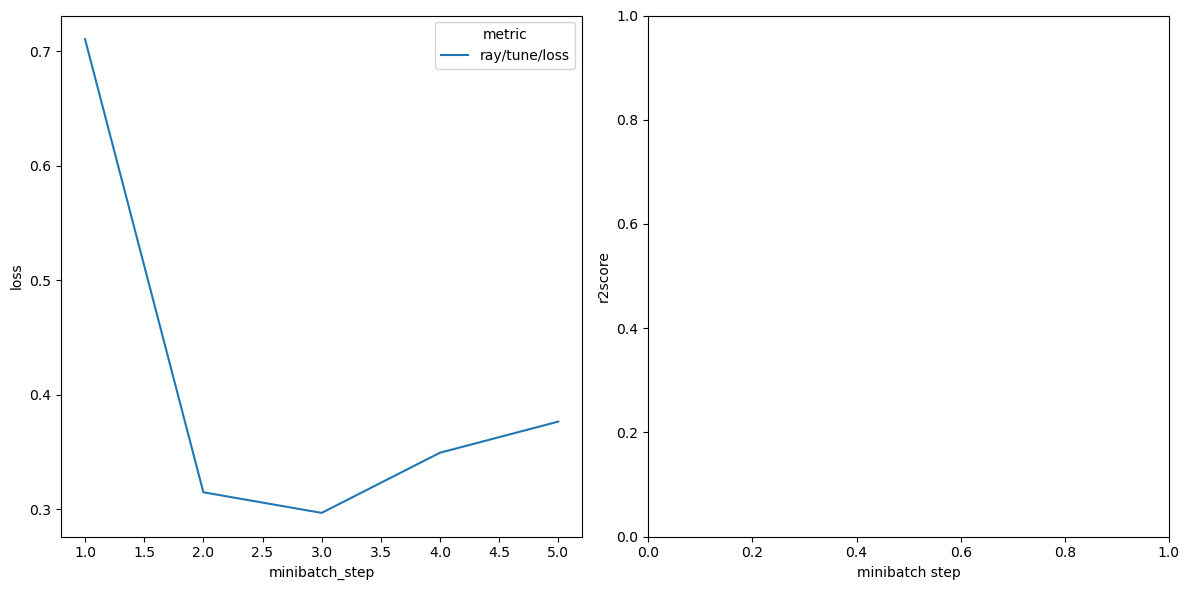

In [13]:
pl.training_summary("/cellar/users/aklie/eugene_logs/hyperopt_with_tune_2023-05-25_14-45-18/hyperopt_with_tune_24db904d_3_batch_size=64,batchnorm=True,conv_channels=512_128_32,conv_kernels=3_7_3,dropout_rates=0.1000,input__2023-05-25_14-47-02", metric="r2score")

In [ ]:
res.results_df.to_csv("hyperopt_results.csv")

# DONE!

---

# Scratch

## Loading a model from a hyperparm config

In [ ]:
config = {
    "module": "SequenceModule",
    "model": {
      "arch_name": "CNN",
      "model_name": "hyper_funkytiger",
      "arch": {
        "input_len": 100,
        "output_dim": 1,
        "conv_kwargs": {
          "input_channels": 4,
          "conv_channels": [256, 256, 256],
          "conv_kernels": [3, 3, 3],
          "pool_kernels": [1, 1, 1],
          "dropout_rates": 0.1,
          "batchnorm": True
        },
        "dense_kwargs": {
          "hidden_dims": [256, 256],
        },
      },
      "task": "regression",
      "loss_fxn": "mse",
      "optimizer": "adam",
      "optimizer_lr": 1e-3,
      "batch_size": 128
    }
}

In [ ]:
module_name = config.pop("module")
batch_size = config["model"].pop("batch_size")
arch_config = config["model"].pop("arch")
arch_name = config["model"]["arch_name"]
arch_type = getattr(importlib.import_module("eugene.models.zoo"), arch_name)
arch = arch_type(**arch_config)
module_type = getattr(importlib.import_module("eugene.models"), module_name)
model = module_type(arch=arch, **config["model"])
print(f"Model: {model}")
models.init_weights(model)

Model: SequenceModule(
  (arch): CNN(
    (conv1d_tower): Conv1DTower(
      (layers): Sequential(
        (0): Conv1d(4, 256, kernel_size=(3,), stride=(1,), padding=valid)
        (1): ReLU()
        (2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.1, inplace=False)
        (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=valid)
        (6): ReLU()
        (7): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
        (8): Dropout(p=0.1, inplace=False)
        (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=valid)
        (11): ReLU()
        (12): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
        (13): Dropout(p=0.1, inplace=False)
        (14): BatchNorm1d(256,